Starting simulation at t=0. s for a duration of 2.5 s
2.5 (100%) simulated in 2s


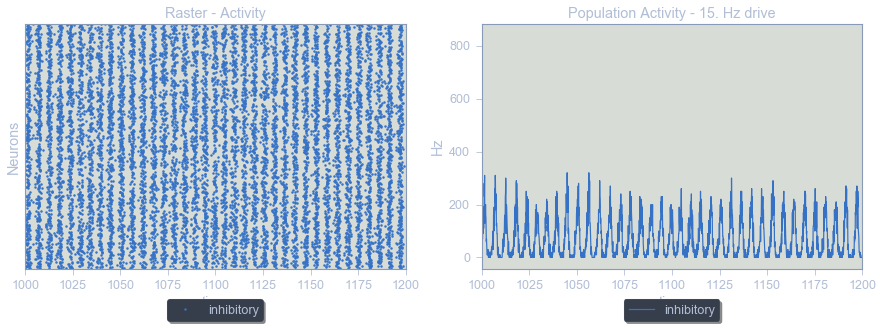

In [1]:
from brian2 import *
from scipy.stats import pearsonr
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

run_time = 2.5 * second
N = 1000
p_con = 0.2
drive = 12 # drive in kHz

N_E = int(N * 0)  # pyramidal neurons
N_I = int(N * 1)  # interneurons

# voltage
V_L = -70. * mV # Resting potential
V_thr = -52. * mV  # Threshold for firing
V_reset = -59. * mV  # Resest voltage
V_E = 0 * mV  # Reversal potential excitatory
V_I = -70. * mV  # Reversal potential inhibitory

# refractory period
tau_E = 2. * ms
tau_I = 1. * ms

# external stimuli  
C_ext = 800  # Number of inputs
dext = drive * 1000
total_input = int(dext / C_ext)
rate = total_input * Hz

# Membrane time constants for I and E
tau_m_I = 10 * ms
tau_m_E = 20 * ms

# Conductances, I
g_GABA_I = 4 * nS #4
g_AMPA_I = 0.3 * nS # 0.3
g_NMDA_I = 0.1 * nS
g_AMPA_ext_I = 0.7 * nS

# Conductances, E
g_GABA_E = 2.5 * nS
g_AMPA_E = 0.19 * nS
g_NMDA_E = 0.06 * nS

# Time constants for GABA
tau_d_GABA = 5 * ms
tau_r_GABA = 0.5 * ms
tau_l_GABA = 1 * ms

# Time constants for poisson inputs
tau_d_Ext = 2 * ms
tau_r_Ext = 0.5 * ms
tau_l_Ext = 1 * ms

# Time constants for AMPA
tau_d_AMPA = 2 * ms
tau_r_AMPA = 0.5 * ms
tau_l_AMPA = 1 * ms

# Time constants for NMDA
tau_d_NMDA = 100 * ms
tau_r_NMDA = 2 * ms
tau_l_NMDA = 1 * ms

# Conductance and Membrane Leak (for correct units)
c_m_I = 0.2 * nF #0.2 * nF
g_m_I = 20 * nS #20. * nS
c_m_E = 0.5 * nF #0.5 * nF
g_m_E = 25 * nS #25. * nS

# Playing with constants
g_AMPA_ext_I = g_AMPA_ext_I * 1
g_GABA_I = g_AMPA_ext_I * 1 
c_m_I = c_m_I * 1
g_m_I = g_m_I * 1

eqs_I = '''
dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt (unless refractory)

I_syn = I_Ext + I_GABA: amp 

I_GABA =  g_GABA_I * (v - V_I) * s_GABA : amp
I_Ext =  g_AMPA_ext_I * (v - V_E) * s_Ext : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
dc_g/dt = -c_g/tau_r_GABA : 1

ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
             (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p-s_Ext)/tau_d_Ext : 1
dc_p/dt = -c_p/tau_r_Ext : 1
'''

P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_I, method='euler')

pre_GABA = '''
c_g += 1
'''

C_P_R = PoissonInput(P_I, 'c_p', C_ext, rate, '1')
P_I.v = V_L
C_I_I = Synapses(P_I, P_I, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_I.connect(condition='i != j', p=p_con)

s_I = SpikeMonitor(P_I)
#M = StateMonitor(P_I, ('v', 'I_GABA_t', 'I_Ext'), record=True)
p_I = PopulationRateMonitor(P_I)

net = Network(P_I, C_P_R, C_I_I, s_I, p_I)
net.run(run_time, report='stdout')

figure(figsize=(15, 5))
subplot(121)
plt.plot(s_I.t / ms, s_I.i*0.025, 'b.', markersize=5, label='inhibitory')
title('Raster - Activity')
xlabel('ms')
yticks([])
xlabel('time')
ylabel('Neurons')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
xlim([1000, 1200])
ylim([0, 20])
subplot(122)
plt.plot(p_I.t / ms, p_I.smooth_rate(width=0.01 * ms) / Hz, 'b-', label='inhibitory')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
title('Population Activity - ' + str(rate) + ' drive')
xlabel('ms')
xlabel('time')
ylabel('Hz')
p_I_mean = np.mean(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
p_I_std = np.std(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
#ylim((p_I_mean - 5*p_I_std, p_I_mean + 5*p_I_std))
xlim([1000, 1200])
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)